In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
from pycbc.filter import make_frequency_series
from calcwf import *
from interpolating_match import *

In [2]:
with open(os.path.join('grid_data', 'dataslot_29', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
grid_data = find_min_max(grid_data)

/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:125: RuntimeWarning: invalid value encountered in sqrt
  num = np.sqrt(data[chirp]['h1']**2+np.cos(angle)*data[chirp]['h-1']**2)
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:58: RuntimeWarning: invalid value encountered in sqrt
  num = np.sqrt(num_sqrd)
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:136: RuntimeWarning: All-NaN slice encountered
  data[chirp][f'{key}_max'] = np.nanmax(np.array(data[chirp][key]), axis=1)
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:137: RuntimeWarning: All-NaN slice encountered
  data[chirp][f'{key}_min'] = np.nanmin(np.array(data[chirp][key]), axis=1)


In [3]:
grid_data.keys()

dict_keys([5.109216918045607, 8.311202280819249, 11.737898138164017, 15.342013196939702, 19.09412877604935, 22.973967099940698, 26.96660856486353, 31.060565479858784, 35.24669064333487, 39.51750973664827, 43.86678863029888, 48.28923991500753, 52.780316430915754, 57.33606154625207])

Text(0, 0.5, 'rho_x/rho_0')

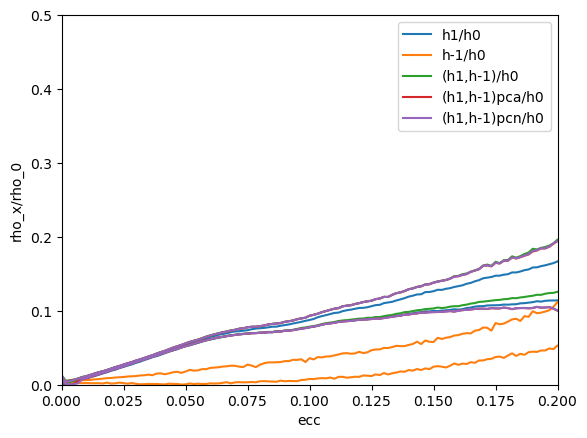

In [27]:
chirp = 15.342013196939702
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_max'], c='C0', label='h1/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_min'], c='C0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_max'], c='C1', label='h-1/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_min'], c='C1')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_max'], c='C2', label='(h1,h-1)/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_min'], c='C2')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_max'], c='C3', label='(h1,h-1)pca/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_min'], c='C3')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_max'], c='C4', label='(h1,h-1)pcn/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_min'], c='C4')
plt.legend()
plt.xlim(0, np.min([0.5, grid_data[chirp]['fid_e']*4]))
plt.ylim(0, 0.5)
plt.xlabel('ecc')
plt.ylabel('rho_x/rho_0')

# Phase consistency

We expect that the difference between the phase of the match with h1 and h0 should be the same as the difference between the phase of the match with h0 and h-1, as they both give estimates of the initial mean anomaly. We can test this here by looking at the discrepancy for every point in the grid.

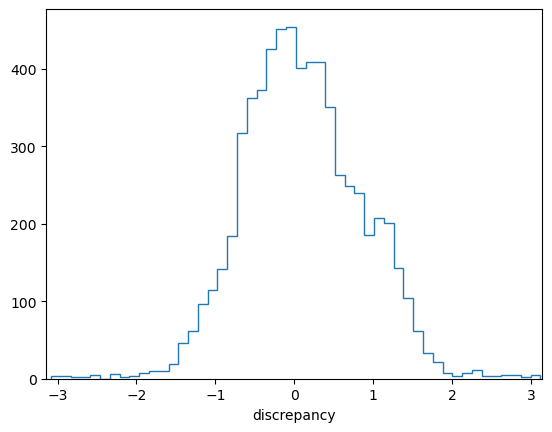

(0.0, 0.5)

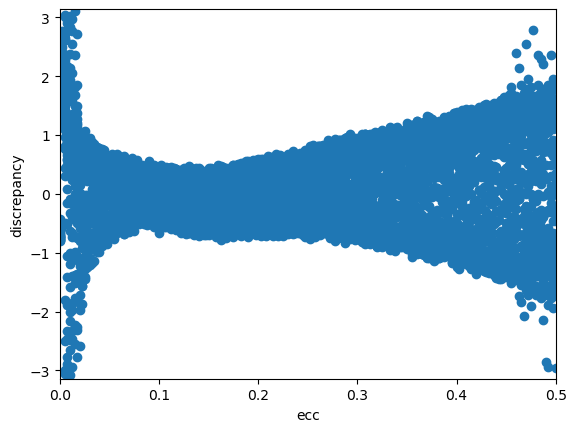

In [5]:
chirp = 31.060565479858784

# Calculating phase differences
h0_phase = grid_data[chirp]['h0_phase']
h1_phase = grid_data[chirp]['h1_phase']
hn1_phase = grid_data[chirp]['h-1_phase']
diff_0 = h1_phase - h0_phase
diff_1 = h0_phase - hn1_phase

# Calculating discrepancies and restricting to between -pi and pi
consistency = diff_1 - diff_0
consistency = (consistency+np.pi)%(2*np.pi)-np.pi

# Plot histogram
plt.hist(consistency.flatten(), bins=50, histtype='step')
plt.xlabel('discrepancy')
plt.xlim(-np.pi, np.pi)
plt.show()

# Plot scatter plot as function of eccentricity along degeneracy line
for i, cons in enumerate(consistency):
    plt.scatter(np.full(len(cons), grid_data[chirp]['e_vals'][i]), cons, c='C0')
plt.ylabel('discrepancy')
plt.xlabel('ecc')
plt.ylim(-np.pi, np.pi)
plt.xlim(0, grid_data[chirp]['e_vals'][-1])

We can see that the discrepancy distribution is indeed centred around zero, supporting our theory that these phase differences should be the same. The discrepancies tend to get bigger at very low eccentricities, likely due to the non/minimal detection of higher harmonics, as well as at high eccentricities, likely due to the similarities to harmonics built at the fiducial eccentricity degrading.